## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline


#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

C:\Users\Kims\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
a_b = 'C:/Users/Kims/Documents/Data_Analysis_2017/statistics/a_b/ab_data.csv'

df = pd.read_csv(a_b)

df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Before getting started with analysis 
I want to look at the data quality 

There are no duplicated records, and no null records. 

Data uniquness is as expected. All timestamps are unique. There are 290 584 unique users. I assmume that group, landing_page, and converted are only supposed to have 2 values. 

In [3]:
# 1) check for duplicates 
print('duplicated', sum(df.duplicated()))
# 2) check for nulls and remove nulls, this is good for python but also for analysis, I do not want to analyze incomplete
# data 
print('look at nulls',df.info()) 
# 3) check for uniqueness
print('uniqueness',df.nunique())

duplicated 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
look at nulls None
uniqueness user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64


b. Use the below cell to find the number of rows in the dataset.

From the describe function, I can see that there are 294 478 rows. 

In [4]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


c. The number of unique users in the dataset.

There are 290 584 unique users. 

In [5]:
unique_users = df.nunique()[0]
unique_users

290584

d. The proportion of users converted.

12.1% of the users were converted. I divided the unique users converted by the unique users.  It turned out that it did not make a big differenced in using unique convertd users.  

In [6]:

users_converted = df[df['converted']== 1].nunique()[0]
users_converted/unique_users 

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

3893 times 'new_page' and 'treatement' don't line up. 

In [7]:
len(df.query('group == "treatment" and landing_page != "new_page" or group != "treatment" and landing_page == "new_page" '))

3893

f. Do any of the rows have missing values?

There are no null (missing) values. 

In [8]:
print('look at nulls',df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
look at nulls None


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page" ')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

There are 290 584 unique User Ids in df2. 

In [11]:
df2.nunique()[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

The duplicated user_id was 773192. 

I used the df.duplicated method to identify the duplicated user_id records and put the records into an nd array. The nd array is by index number and bollean. I then converted the nd array into a dataframe and got the duplicated record index number. I used df.loc to find the user_id and query to verify that I have the correct result.   

In [12]:

# I used the df2, duplicate to identify invidual duplicated records, I played around to make this work 
# because the documenation was not the best 
unique =  df2.duplicated(subset='user_id',keep=False)
# I understood that df.duplicated made a ndarray, I finally decided the best thing to do was to convert into a 
# DataFrame 
unique_df = pd.DataFrame(unique,columns=['unique'])
# I could then identify the duplicated records 
print((unique_df.query('unique == True')))
# I used df.loc to find the user_id and query to verify that I have the correct answer 
df2.loc[2893]
df2.query('user_id == 773192')





      unique
1899    True
2893    True


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**?

Row numbers are 1899 and 2893. 

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

I turned of the chained assignment warning - I got the idea here: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas . 

I used print infor to make sure that my datafram is only one record less. 

In [14]:
print(df2.info())
pd.options.mode.chained_assignment = None  # default='warn'
df2.drop([1899],inplace=True)
print(df2.info())


#df.drop([0, 1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 23.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

11.96% of the users converted. 

In [15]:
total_users = len(df2)
converted_users = len(df2.query('converted==1'))
converted_users/total_users

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

12.04% of the 'control' users converted. 

In [16]:

control_users = len(df2.query('group =="control"'))
control_converted_users = len(df2.query('group =="control" and converted ==1'))
control_converted_users/control_users

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

11.9 % of the 'treatment group users converted. 

In [17]:
treatment_users = len(df2.query('group =="treatment"'))
treatment_converted_users = len(df2.query('group =="treatment" and converted ==1'))
treatment_converted_users/treatment_users

0.11880806551510564

d. What is the probability that an individual received the new page?

There is a 50% possibility thea an individual received a new page. P.S. I understand that treatment_users == new_page_users,  but this is a good verification excercies. 

In [18]:
new_page_users = len(df2.query('landing_page == "new_page"'))
new_page_users/total_users

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

It will be interesting to do the A/B tests.  Based on the conditional probabilities, it looks like the new page does not result in more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

P null: old page conversions > = new page converstions, P alternative: new page conversions > old page conversions

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

Because "p_new and  p_old both have "true" success rates equal to the converted success rate regardless of page - that is  pnewpnew  and  poldpold  are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page", the null hypothesis is the population mean (.119597). 

In [19]:

p_new = df2['converted'].mean()
p_new



0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

Because "p_new and  p_old both have "true" success rates equal to the converted success rate regardless of page - that is  pnewpnew  and  poldpold  are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page", the null hypothesis is the population mean (.119597). 


In [20]:

p_old = df2['converted'].mean()
p_old


0.11959708724499628

c. What is $n_{new}$?

n_new is found from finding the landing_page equal to new page.  N_new has 145 310 records. 

I have make a n_new dataframe with landing page equal to new page for use in further analysis. 

In [21]:
df2.head()
n_new = df2.query('landing_page == "new_page"')

len(n_new)


145310

d. What is $n_{old}$?

n_old is found from finding the landing_page equal to old page.  N_old has 145 274 records. 

I have make a n_old dataframe with landing page equal to old page for use in further analysis.

In [22]:
n_old = df2.query('landing_page == "old_page"')
len(n_old)



145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

I made a new dataframe from n_new that only have the 'converted' values to use less computer memory.  I then used the boot strap method to sample only n_new records and replace = true to have a new set of boot samples for each iteration. As instructed, I performed 10 000 iterations. I printed out each iteration so that I could follow the exectution of the iterations - this takes about 10-15 minutes because I do not have a business computer at home. 

In [23]:
n_new_converted = n_new['converted']
new_page_converted = []
count = 0 
for _ in range(10000):
    boot_sample = n_new_converted.sample(len(n_new),replace=True)
    sample_new = boot_sample.mean()
    new_page_converted.append(sample_new-p_new)
    count +=1
    #print('running',count)

# Curious about the results 
This was not required, but I converted the list into a series and made a historgram.  By converting into a series, I could get statstics and look at confidence intervals. As expected, less users convert used the new page, but the difference from the population means is very small (-.00078). 

sample mean -0.000788403740763947
sample standard deviation 0.0008422026081919175
lower 2.5% confidence -0.00241330773911
upper 97.5% confidence 0.00089031898995
describe count    10000.000000
mean        -0.000788
std          0.000842
min         -0.003913
25%         -0.001374
50%         -0.000796
75%         -0.000225
max          0.002411
dtype: float64


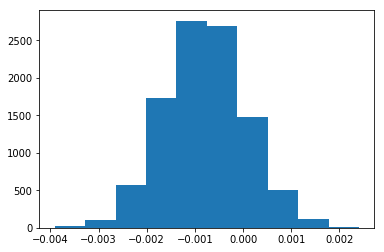

In [24]:
new_page_converted[50:60]
plt.hist(new_page_converted)
s = pd.Series(new_page_converted)
print('sample mean',s.mean())
print('sample standard deviation', s.std())
print('lower 2.5% confidence',np.percentile(s,2.5))
print('upper 97.5% confidence',np.percentile(s,97.5))
print('describe',s.describe())


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

I made a new dataframe from n_old that only have the 'converted' values to use less computer memory. I then used the boot strap method to sample only n_old records and replace = true to have a new set of boot samples for each iteration. As instructed, I performed 10 000 iterations. I printed out each iteration so that I could follow the exectution of the iterations - this takes about 10-15 minutes because I do not have a business computer at home.

In [25]:
n_old_converted = n_old['converted']
old_page_converted = []
count = 0 
for _ in range(10000):
    boot_sample = n_old_converted.sample(len(n_old),replace=True)
    sample_new = boot_sample.mean()
    old_page_converted.append(sample_new-p_old)
    count +=1
    #print('running',count)

# Curious about the results 
This was not required, but I converted the list into a series and made a historgram.  By converting into a series, 
I could get statstics and look at confidence intervals. As expected, more users convert used the old page, but the 
difference from the population means is very small  (.0007913.) 

sample mean 0.0007913305035340821
sample standard deviation 0.0008552049182563617
lower 2.5% confidence -0.000890367529149
upper 97.5% confidence 0.00248256912848
describe count    10000.000000
mean         0.000791
std          0.000855
min         -0.002384
25%          0.000218
50%          0.000775
75%          0.001367
max          0.004121
dtype: float64


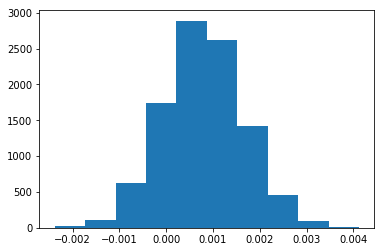

In [26]:

plt.hist(old_page_converted)
t = pd.Series(old_page_converted)
print('sample mean',t.mean())
print('sample standard deviation', t.std())
print('lower 2.5% confidence',np.percentile(t,2.5))
print('upper 97.5% confidence',np.percentile(t,97.5))
print('describe',t.describe())


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

I have calcualted -0.00158 convert using the new page

In [27]:
new_null = s.mean() - t.mean()
new_null

-0.001579734244298029

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

I return to my original hypothesis.
P null: old page conversions > = new page converstions, P alternative: new page conversions > old page conversions

I sample from the whole dataframe, but I make two dataframes from the random sample: old_df and new_df. I then calculated a converted mean for each dataframe.  I append to the p_diffs_list2 the difference between the old_page converted mean and new_page converted mean. 

To save computer memory I made a sampling dataframe.  I also have a for statement print so that I can know the progress of my for statement. 

I got the idea to do this from the Udacity Completion rate excercise. 

In [28]:
df2_converted = df2[['landing_page','converted']]
p_diffs_list2 = []
count = 0 
for _ in range(10000):
    boot_sample = df2_converted.sample(len(df2),replace=True)
    old_df = boot_sample.query('landing_page == "old_page"')
    new_df = boot_sample.query('landing_page == "new_page"')
    old_mean = old_df['converted'].mean()
    new_mean = new_df['converted'].mean()
    p_diffs_list2.append(new_mean-old_mean)
    count +=1
    #print('running',count)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

I make a histogram from the p_diff_list2 list and convert it into a series so that I make some statistics. 

The plot does look as expected - it is normally distribued. The results confirm that there is conversion using the new_page because the sample mean is -.001599 representing the -1,59% were less converted using the new_page. 

sample mean -0.0015946669763910366
sample standard deviation 0.0011913762951164127
lower 2.5% confidence -0.00391221965213
upper 97.5% confidence 0.000725105313659
describe count    10000.000000
mean        -0.001595
std          0.001191
min         -0.006224
25%         -0.002399
50%         -0.001591
75%         -0.000781
max          0.003313
dtype: float64


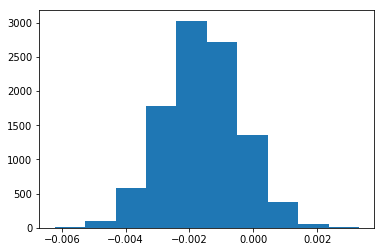

In [29]:
plt.hist(p_diffs_list2)
u = pd.Series(p_diffs_list2)
print('sample mean',u.mean())
print('sample standard deviation', u.std())
print('lower 2.5% confidence',np.percentile(u,2.5))
print('upper 97.5% confidence',np.percentile(u,97.5))
print('describe',u.describe())

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

The calculated pvalue is .91.  



null values mean 8.84367280862e-06
actual difference mean -0.0015782389853555567


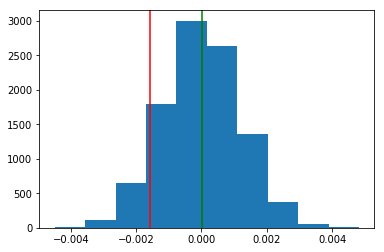

In [30]:
null_vals = np.random.normal(0,u.std(),len(u))
actual_difference = df2.query('landing_page == "new_page"') ['converted'].mean() - df2.query('landing_page == "old_page"') ['converted'].mean()

# Plot the null distribution
# plot line for observed statistic

plt.hist(null_vals)
plt.axvline(x=actual_difference,color = 'red')
plt.axvline(x=null_vals.mean(),color = 'green')
print('null values mean', null_vals.mean())
print('actual difference mean',actual_difference)

In [31]:
# compute p value
pvalue = (null_vals > actual_difference).mean()
pvalue


0.90700000000000003

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

 

**Put your answer here.**


# The pval>α⇒ Fail to Reject the Null Hypothesis". I read through the internet to understand what is a p value. I liked this article: http://trendingsideways.com/index.php/the-p-value-formula-testing-your-hypothesis/ . 
# To me in simpler English, I would say that the P value means that I can continue data analysis if I "Fail to Reject the Null Hypothesis".  But it says nothing about the statistic itself - should I use the old or new payget. What it says is that I can look at the confidence intervals. 

# Then I continued to read the internet to understand what I have done for the P value calculation. Ironically, the answer was right in front of my nose right here: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a45f86_dand-syllabus-v7-terms-1/dand-syllabus-v7-terms-1.pdf . I believe I have confirmed that I have learned to perform a T test: https://en.wikipedia.org/wiki/Student%27s_t-test . This is a fun article - Udacity could add it to the lecture, but it look like Udacity wants us to find this for ourselves. 


# As I reflected on this more, the hypothesis is proven for 10 000 random selection simulations of the data set.  From the law of large numbers, we can be pretty convinced about this population. But the user can and will change.  This is why, business people will regularly want to monitor results. For example, a marketing campaign could change the types of users that we are reaching and could result in different results then expected.  

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

# I start with calculating proportions. 

In [32]:
import statsmodels.api as sm

convert_old = len(df2.query('group =="control" and converted ==1'))
convert_new = len(df2.query('group =="treatment" and converted ==1'))
n_old_count = len(n_old)
n_new_count = len(n_new)
print('old converstion',convert_old/n_old_count)
print('new converstion',convert_new/n_new_count)
print(convert_old,convert_new,n_old_count,n_new_count)




old converstion 0.1203863045004612
new converstion 0.11880806551510564
17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

# The calculated Z score is 1.311 and the Z score acceptance range is from .905 to 1.95996.  I was puzzled that the alternative value does not change the Z value, but as I think about that more it is bcause the alternative values is all about the null hypotheses.   We can Fail to Reject the null hypothesis because the P value of .19 is greater than 0 - I got this from a 5% confidence and one degree of freedom from this table: https://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf.  

In [33]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm


counts = np.array([convert_old, convert_new])
nobs = np.array([n_old_count, n_new_count])


#z_score, pval = proportions_ztest(counts, nobs, alternative='larger')
z_score, pval = proportions_ztest(counts, nobs)
print('{0:0.3f}'.format(z_score))
print('{0:0.10f}'.format(pval))
norm.cdf(z_score)
print(norm.cdf(z_score))
# 0.9999999383005862 # Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
print(norm.ppf(1-(0.05/2)))
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

1.311
0.1898833745
0.905058312759
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?  

**Put your answer here.**

# In J we calculated a Test Test.  In K, we calcualted a chi square.  That is why I look at the chi square table to validate the p value. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic regression 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

# I make a df3 dataframe. I make dummies making new_page as my value and and intercept. 

In [34]:
df3 = df2
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:

df3['new_page'] = pd.get_dummies(df['landing_page'])['new_page'] # I want to now use new_page to see I should use it  
df3['intercept'] = 1 
df3.head()



,user_id,timestamp,group,landing_page,converted,new_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'new_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:00:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [38]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
# old page is .985 times less likely to be convert 
1/np.exp(.0150)

0.98511193960306276

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

The Z value is now with the opposite sign with the proportions_ztest because I am using new_page with my intercept value. The P value is different from part two bacause I can now see that sm.Logit use also the chi square for calculating the p value - just like the proportions_ztest - the p value match.  The logistic regression also confirms that the new page shold not be used .985 times likely conversion.   

I have learned when drawing conclusions you need to be skeptical - this I have also learned in my business life.  Now we have used 3 different methods to confirm or test results: we have used logistic regression, the proportions_ztest, and the T test. In all instances we have confirmed that we should stick with the old page.  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

# Adding other factors can give a better understanding of the statistical results.  For example extra data from cookies could be added. Adding too many factors may make the model hard to understand.  You also need to be careful that the X vairables are not related, but that they are independent of one another.  This is where the regression models P scores can help. 

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question. I will answer step by step. 

In [39]:
country = 'C:/Users/Kims/Documents/Data_Analysis_2017/statistics/a_b/countries.csv'

countries_df = pd.read_csv(country)

countries_df.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


# Before getting started with analysis 
I want to look at the data quality 

There are no duplicated records, and no null records. 

Data uniquness is as expected, there are three countries in the dataframe (I looked at this in an excel. There are 290 584 records which matched df2 - so the join should work as expected.

In [40]:
# 1) check for duplicates 
print('duplicated', sum(countries_df.duplicated()))
# 2) check for nulls and remove nulls, this is good for python but also for analysis, I do not want to analyze incomplete
# data 
print('look at nulls',countries_df.info()) 
# 3) check for uniqueness
print('uniqueness',countries_df.nunique())

duplicated 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB
look at nulls None
uniqueness user_id    290584
country         3
dtype: int64


# join countries to df_new

In [41]:

df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,new_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


# I was curious about how the countries affected the logistic regression analysis so I make 3 dataframes. 

In [42]:
### Create the necessary dummy variables
df_new1 = df_new.copy()
df_new1['new_page'] = pd.get_dummies(df_new1['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new1['intercept'] = 1
df_new1['UK'] = pd.get_dummies(df_new1['country']) ['UK']
df_new1['CA'] = pd.get_dummies(df_new1['country']) ['CA']
df_new1.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [43]:
### Create the necessary dummy variables
df_new2 = df_new.copy()
df_new2['new_page'] = pd.get_dummies(df_new2['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new2['intercept'] = 1
df_new2['US'] = pd.get_dummies(df_new2['country']) ['US']
df_new2['CA'] = pd.get_dummies(df_new2['country']) ['CA']
df_new2.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,US,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [44]:
### Create the necessary dummy variables
df_new3 = df_new.copy()
df_new3['new_page'] = pd.get_dummies(df_new3['landing_page'])['new_page'] # this is how to get the weekday without dropping weekend
df_new3['intercept'] = 1
df_new3['US'] = pd.get_dummies(df_new3['country']) ['US']
df_new3['UK'] = pd.get_dummies(df_new3['country']) ['UK']
df_new3.head()




,country,timestamp,group,landing_page,converted,new_page,intercept,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new1['converted'], df_new1[['intercept', 'new_page','UK','CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        08:00:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [46]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),np.exp(.0099),1/np.exp(.0408)

(0.9852104557227469, 1.0099491671175422, 0.96002111497165088)

# the new_page conversion rate stays at .985.  The UK has a .01 conversion rate, but Canada had a .96 conversion rate. 

In [47]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new2['converted'], df_new2[['intercept', 'new_page','US','CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        08:00:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

In [48]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),1/np.exp(.0099),1/np.exp(.0506)

(0.9852104557227469, 0.99014884368295708, 0.95065885803307093)

# When you put the US and Canada together, the US has a .99 conversion rate while Canada has a .95 conversion rate.  I was starting to think maybe the new_page would work in other countries better, but that did not turn out to be true. 

In [49]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new3['converted'], df_new3[['intercept', 'new_page','US','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        08:00:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [50]:
# to interpet the logical regression results, the variable need to be exponeted, if negative needs to divide 1 by the 
#exponent
1/np.exp(.0149),np.exp(.0408),np.exp(.0506)

(0.9852104557227469, 1.0416437559600236, 1.0519020483004984)

# When you analyze the US and UK together, you can see that the US has a 1.042 conversion rate, while the UK has a 1.052 conversion rate. 

In [51]:
print('Number of UK unique users',len(df_new.query('country == "UK"'))) 
print('Number of CA unique users',len(df_new.query('country == "CA"')))
print('Number of US unique users',len(df_new.query('country == "US"')))
#df_new.query('country == "CA"')['converted'].mean()
print('Mean of Canada old_page converted',df_new.query('country == "CA" and landing_page == "old_page"') ['converted'].mean())
print('Mean of Canada new_page converted',df_new.query('country == "CA" and landing_page == "new_page"') ['converted'].mean())
print('Mean of UK old_page converted',df_new.query('country == "UK" and landing_page == "old_page"') ['converted'].mean())
print('Mean of UK new_page converted',df_new.query('country == "UK" and landing_page == "new_page"') ['converted'].mean())
print('Mean of US old_page converted',df_new.query('country == "US" and landing_page == "old_page"') ['converted'].mean())
print('Mean of US new_page converted',df_new.query('country == "US" and landing_page == "new_page"') ['converted'].mean())

Number of UK unique users 72466
Number of CA unique users 14499
Number of US unique users 203619
Mean of Canada old_page converted 0.11878299527646569
Mean of Canada new_page converted 0.11190247911245035
Mean of UK old_page converted 0.12002200220022002
Mean of UK new_page converted 0.1211709965102753
Mean of US old_page converted 0.12062998938220143
Mean of US new_page converted 0.11846559963887227


# I decided to make statistics for the dataframe joined with country. Canada has 14 499 users, but Canada also has the lowest conversion rates.  11.9% for the old page and 11.2% for the new_page. 

# UK has 72466 users, and the  UK the has conversion rates of 12.0% for the old page and 12.1% for the new_page. The new_page is very marginally better.  


# US has 203 619 users, and the  Us the has conversion rates of 12.1% for the old page and 11.85% for the new_page.

# There are country difference, but it looks the new new page will not help us in other countries. 

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.